## This notebook simulates a flock of birds using the Boid model

#### create the dataset in pytorch format
Positions: (rollout steps ahead, number of boids, 2)
ex: (100 frames, 20 boids, 2 dimensions)

Species: a list of num_boid entries of each boid’s identity, (number of boids)
ex: ['goose', 'goose', 'crane', 'crane', 'crane']

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch_geometric.data import DataLoader

In [3]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [4]:
import os

from collab_env.data.file_utils import expand_path, get_project_root

# our code
from collab_env.sim.boids_gnn_temp.animal_simulation import (
    AnimalTrajectoryDataset,
    visualize_graph,
)
from collab_env.sim.boids_gnn_temp.boid import init_multi_species_boids, update_boids

# %%


smoke_test = "CI" in os.environ

steps = 800 if not smoke_test else 10
num_samples = 1000
# %%

In [5]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 7,
        "counts": 20,
        "independent": False
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=num_samples,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_basic_large.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_basic_large_config.pt", get_project_root()
    ),
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### (ablation dataset) weak alignment

In [6]:
species_configs["A"]["matching_factor"] = 0.01

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples = num_samples,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_weakalignment_large.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_weakalignment_large_config.pt", get_project_root()
    ),
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### (ablation dataset) no repulsion

In [7]:
species_configs["A"]["avoid_factor"] = 0

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples = num_samples,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_norepulsion_large.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_norepulsion_large_config.pt", get_project_root()
    ),
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### independent

In [8]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 7,
        "counts": 20,
        "independent": True
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples = num_samples,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_independent_large.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_independent_large_config.pt", get_project_root()
    ),
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### strong alignment

In [39]:
species_configs["A"]["matching_factor"] = 1

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=480,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_strong_alignment.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_strong_alignment_config.pt", get_project_root()
    ),
)

### Short version

In [7]:
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 50,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,
        "margin": 5,  # 0.05, 25
        "turn_factor": 10,
        "speed_limit": 20,
        "counts": 20,
    }
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=10,
    num_samples=50,
    seed=2025,
)

torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_short.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_short_config.pt", get_project_root()
    ),
)

### A bit faster flying bird

In [8]:
velocity_scale = 30

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=steps,
    num_samples=50,
    velocity_scale=velocity_scale,
    seed=2026,
)  # 50 videos of 1000 frames (5 steps advanced forward) each

torch.save(
    dataset,
    expand_path(
        "simulated_data/boid_single_species_high_cluster_high_speed.pt",
        get_project_root(),
    ),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_high_cluster_high_speed_config.pt",
        get_project_root(),
    ),
)

### Noisy birds

In [9]:
species_configs["A"]["matching_factor"] = 0.1


dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids,
    species_configs,
    width=640,
    height=480,
    steps=steps,
    num_samples=50,
    seed=2025,
)
torch.save(
    dataset,
    expand_path("simulated_data/boid_single_species_noisy.pt", get_project_root()),
)
torch.save(
    species_configs,
    expand_path(
        "simulated_data/boid_single_species_noisy_config.pt", get_project_root()
    ),
)

### Plot data

In [30]:
#file_name = 'boid_food_basic_alignment.pt'
#config_name = 'boid_food_basic_alignment_config.pt'

file_name = 'boid_single_species_basic.pt'
config_name = 'boid_single_species_basic_config.pt'

#file_name = 'boid_single_species_independent.pt'
#config_name = 'boid_single_species_independent_config.pt'

dataset = torch.load(expand_path(
        "simulated_data/" + file_name, get_project_root()), weights_only = False)
species_configs = torch.load(expand_path(
        "simulated_data/" + config_name, get_project_root()), weights_only = False)

In [31]:
batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(loader))
p, species = batch

print("made", str(len(list(loader))), "batches, each of size", str(batch_size))  #
print("Positions:", p.shape)  # [B, steps, N, 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 50 batches, each of size 1
Positions: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




### Visualize boids

p0 shape torch.Size([20, 2])
p shape torch.Size([1000, 20, 2])


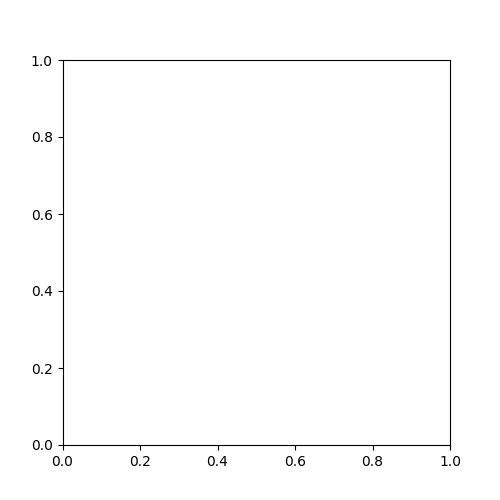

In [32]:
%matplotlib widget
global ani

file_id = 7
batch = list(iter(loader))[file_id]
p, species = batch
v = torch.diff(p, axis = 1) 

_, F, _2, dim = p.shape
starting_frame = int(round(3*F/4))
ani, _ = visualize_graph(p[0,:], v[0], species = species, batch = None, starting_frame = 0, file_id = 0, ending_frame = 1000)